In [31]:
from astropy.table import Table
import astropy.units as au
import astropy.constants as ac

In [34]:
data = Table.read(
    "data.dat",
    header_start=None,
    data_start=8,
    delimiter="\t",
    format="ascii.basic",
    names=["wavelength", "logflux", "error_logflux"]
)
data

wavelength,logflux,error_logflux
float64,float64,float64
22.194,-16.307417185997757,0.08685889638065036
3.6,-18.062510866962743,0.04342944819032518
4.5,-17.17263919421517,0.04342944819032518


In [90]:
import numpy as np


# Get constants in our unit system (flux in erg / s / cm / angstrom)
HC = (ac.hbar * ac.c * 2 * np.pi).to_value(au.erg * au.micron)
KB = (ac.k_B).to_value(au.erg / au.K)
C = (ac.c).to_value(au.micron / au.s)

log_HCC = np.log10(HC * C)

def log_planck(wavelength):
    HCLKB = HC / (wavelength * KB)
    log_wavelength5 = 5 * np.log10(wavelength)
    def _log_planck(alpha, T):
        return log_HCC - log_wavelength5 - np.log10(
            (np.exp(HCLKB/T) - 1) / alpha 
        )
    return _log_planck

def log_likelihood_planck(wavelength, logflux, error_logflux):
    _log_planck_model = log_planck(wavelength)
    _log_planck_data = logflux
    _log_planck_error2 = 2*(error_logflux**2)

    def _log_likelihood_planck(y):
        return - np.sum((_log_planck_data - _log_planck_model(np.exp(y[0]), y[1]))**2 / _log_planck_error2)

    return _log_likelihood_planck

def log_prior_brown_dwarf(y):
    return 0. if y[1] >= 0 and y[1] <= 1000 else -np.inf


In [227]:
step = np.array((0.05, 0.5))

def walk(factory, initial_guess, *args, steps=40000, seed=None, **kwargs):
    _log_likelihood_fn = factory(*args, **kwargs)

    initial_guess = np.asarray(initial_guess)
    assert len(initial_guess.shape) == 1
    shapeN = initial_guess.shape[0]
    state = np.full((steps, shapeN), np.nan)

    log_likelihood = np.full((steps,), np.nan)
    state[0, :] = initial_guess
    log_likelihood[0] = _log_likelihood_fn(initial_guess)

    rg = np.random.default_rng(seed)

    # _norm_sample = rg.normal(size=(steps, shapeN))
    # step_vec = step * (_norm_sample / np.linalg.norm(_norm_sample, axis=1)[:, np.newaxis])

    _norm_sample = 2 * (rg.normal(size=(steps, shapeN))-0.5)
    step_vec = step * _norm_sample

    for i in range(1, steps):
        proposal = state[i-1] + step_vec[i]
        new_likelihood = _log_likelihood_fn(proposal)
        ll_diff = new_likelihood - log_likelihood[i-1]
        
        # Metropolis method
        if ll_diff > 0.0 or np.log(rg.random()) < ll_diff:
            state[i, :] = proposal
            log_likelihood[i] = new_likelihood
        else:
            state[i, :] = state[i-1]
            log_likelihood[i] = log_likelihood[i-1]

    return state, log_likelihood

In [228]:
state, log_likelihood = walk(log_likelihood_planck, (-10, 200), data["wavelength"], data["logflux"], data["error_logflux"])

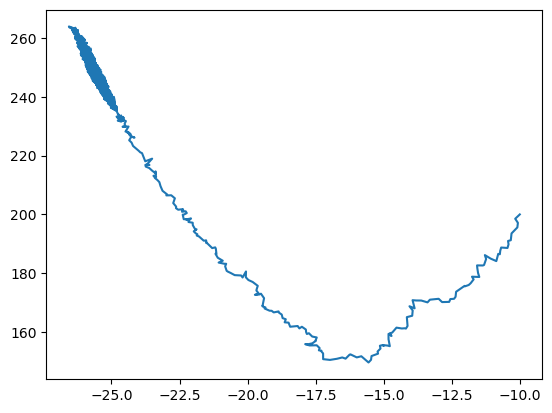

In [229]:
import matplotlib.pyplot as plt

plt.plot(*state.T)

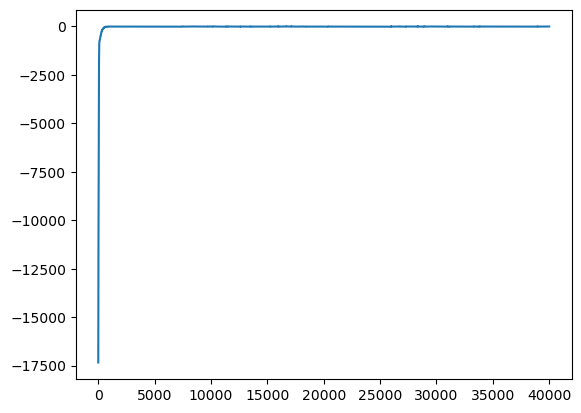

In [230]:
plt.plot(log_likelihood)

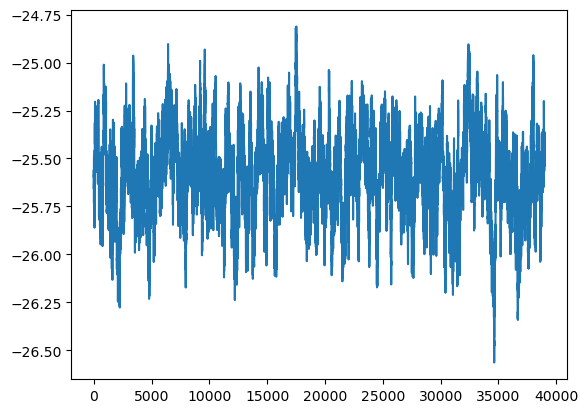

In [231]:
plt.plot(state[1000:, 0])

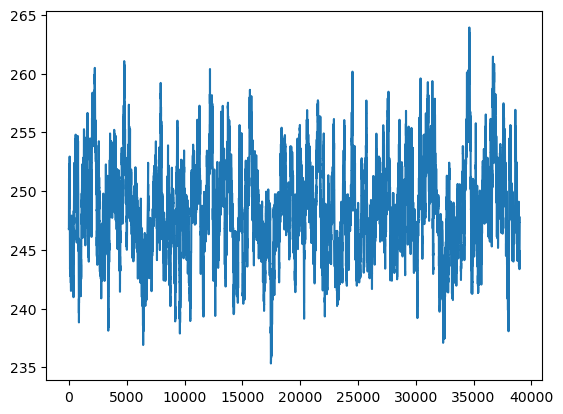

In [232]:
plt.plot(state[1000:, 1])